In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import librosa.display
from scipy.io import wavfile
import numpy as np
import pandas as pd
from scipy.io import wavfile
from spleeter.separator import Separator
from spleeter.audio.adapter import AudioAdapter

In [3]:
# Constants
PATH = '/home/steffen/Datasets/gtzan/'
DATA_SET = PATH + 'genres_original/'
META_DATA_3_SEC = PATH + 'features_3_sec.csv'
META_DATA_30_SEC = PATH +'features_30_sec.csv'

In [22]:
df = pd.read_csv(META_DATA_30_SEC)
df = df[['filename', 'label']]

for (index, filename_col, label_col) in df.itertuples():
    df.loc[[index],['filename']] = DATA_SET + label_col + '/' + filename_col

display(df)

genres_dict = {}
genres = df['label'].unique()
for label in genres:
    genres_dict.update({label: len(genres_dict)})

# Encode labels as int
df['label'] = df['label'].apply(lambda label: genres_dict[label])
display(df)

# Swao dict keys and values
genres_dict = dict([(value, key) for key, value in genres_dict.items()]) 
genres_dict = np.array(list(genres_dict.items()))
display(genres_dict)

# and back
genres_dict = dict([(key, value) for key, value in genres_dict])
display(genres_dict)



,filename,label
0,/home/steffen/Datasets/gtzan/genres_original/b...,blues
1,/home/steffen/Datasets/gtzan/genres_original/b...,blues
2,/home/steffen/Datasets/gtzan/genres_original/b...,blues
3,/home/steffen/Datasets/gtzan/genres_original/b...,blues
4,/home/steffen/Datasets/gtzan/genres_original/b...,blues
...,...,...
995,/home/steffen/Datasets/gtzan/genres_original/r...,rock
996,/home/steffen/Datasets/gtzan/genres_original/r...,rock
997,/home/steffen/Datasets/gtzan/genres_original/r...,rock
998,/home/steffen/Datasets/gtzan/genres_original/r...,rock


,filename,label
0,/home/steffen/Datasets/gtzan/genres_original/b...,0
1,/home/steffen/Datasets/gtzan/genres_original/b...,0
2,/home/steffen/Datasets/gtzan/genres_original/b...,0
3,/home/steffen/Datasets/gtzan/genres_original/b...,0
4,/home/steffen/Datasets/gtzan/genres_original/b...,0
...,...,...
995,/home/steffen/Datasets/gtzan/genres_original/r...,9
996,/home/steffen/Datasets/gtzan/genres_original/r...,9
997,/home/steffen/Datasets/gtzan/genres_original/r...,9
998,/home/steffen/Datasets/gtzan/genres_original/r...,9


array([['0', 'blues'],
       ['1', 'classical'],
       ['2', 'country'],
       ['3', 'disco'],
       ['4', 'hiphop'],
       ['5', 'jazz'],
       ['6', 'metal'],
       ['7', 'pop'],
       ['8', 'reggae'],
       ['9', 'rock']], dtype='<U21')

{'0': 'blues',
 '1': 'classical',
 '2': 'country',
 '3': 'disco',
 '4': 'hiphop',
 '5': 'jazz',
 '6': 'metal',
 '7': 'pop',
 '8': 'reggae',
 '9': 'rock'}

In [28]:
split = {}
split['train'], split['validate'], split['test'] = np.split(
    df.sample(frac=1).reset_index(drop=True), 
    [int(.6*len(df)), int(.8*len(df))]
)
display(split)

{'train':                                               filename  label
 0    /home/steffen/Datasets/gtzan/genres_original/c...      2
 1    /home/steffen/Datasets/gtzan/genres_original/b...      0
 2    /home/steffen/Datasets/gtzan/genres_original/r...      9
 3    /home/steffen/Datasets/gtzan/genres_original/m...      6
 4    /home/steffen/Datasets/gtzan/genres_original/c...      2
 ..                                                 ...    ...
 595  /home/steffen/Datasets/gtzan/genres_original/m...      6
 596  /home/steffen/Datasets/gtzan/genres_original/m...      6
 597  /home/steffen/Datasets/gtzan/genres_original/r...      9
 598  /home/steffen/Datasets/gtzan/genres_original/p...      7
 599  /home/steffen/Datasets/gtzan/genres_original/b...      0
 
 [600 rows x 2 columns],
 'validate':                                               filename  label
 600  /home/steffen/Datasets/gtzan/genres_original/r...      8
 601  /home/steffen/Datasets/gtzan/genres_original/r...      8
 602  /

In [13]:
# Testfiles
file_path_1 = df['filename'][0]
file_path_2 = df['filename'][333]
file_path_3 = df['filename'][666]
file_path_4 = df['filename'][999]


In [16]:
# Spleeter
audio_loader = AudioAdapter.default()
sample_rate = 44100
waveform = audio_loader.load(file_path_4, sample_rate=44100)

seperator = Separator('spleeter:4stems')
prediction = seperator.separate(waveform, "")



INFO:tensorflow:Apply unet for vocals_spectrogram
INFO:tensorflow:Apply unet for drums_spectrogram
INFO:tensorflow:Apply unet for bass_spectrogram
INFO:tensorflow:Apply unet for other_spectrogram


NotImplementedError: Cannot convert a symbolic Tensor (strided_slice_4:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [46]:
def create_spectrogram(waveform):
    spectrogram = tf.signal.stft(np.squeeze(waveform), frame_length=256, frame_step=128, window_fn=tf.signal.hamming_window)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

def plot_spectrogram(spectrogram):
    spectrogram = librosa.amplitude_to_db(spectrogram.numpy(), ref=np.max)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(spectrogram.T, x_axis='time', y_axis='log', ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.f dB")


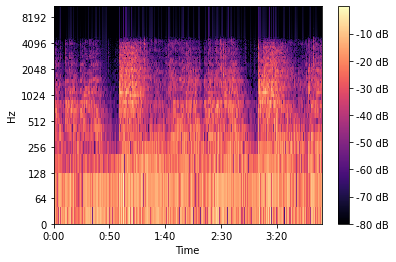

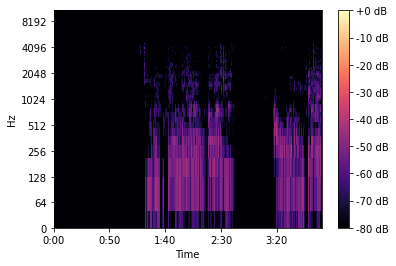

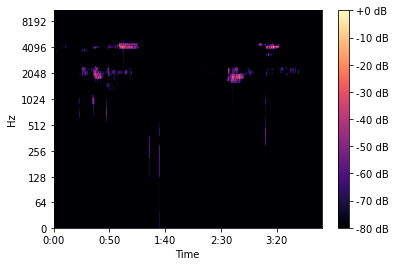

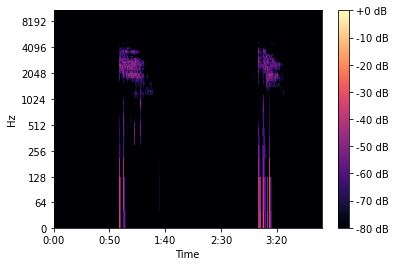

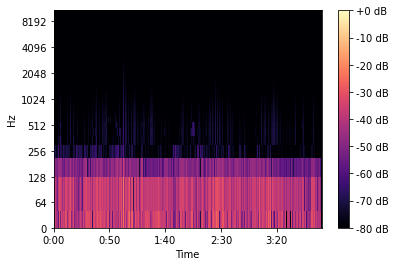

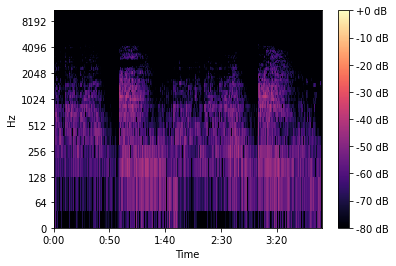

In [47]:
spec_dict = {}
spec_dict['original'] = create_spectrogram(waveform)


# The Original file seems to be mono but spleeter outputs stereo to to match the original
for key in prediction:
    spec_dict[key] = create_spectrogram(np.delete(prediction[key], 1,1))

for key in spec_dict:
    plot_spectrogram(spec_dict[key])
